In [4]:
import json
from pprint import pprint

In [26]:
channel_type = 'atn'

if channel_type == 'awgn':
    file_list = [
        '../test_logs/turboae-approximated-nonsys_basic_2022-01-05.02-26-57.json',
        '../test_logs/turboae-approximated-rsc2_hazzys_2022-01-06.07-39-13.json',
        '../test_logs/turboae-approximated-rsc2_hazzys_2022-01-08.13-48-19.json',
    ]
    num_samples = [int(1e6), int(1e5), int(9e5)] 
elif channel_type == 'atn':
    file_list = [
        '../test_logs/turboae-approximated-nonsys_basic_2022-01-05.10-54-15.json',
        '../test_logs/turboae-approximated-rsc2_hazzys_2022-01-06.08-19-00.json',
        '../test_logs/turboae-binary-exact_basic_2022-01-08.12-01-52.json',
        '../test_logs/turboae-approximated-rsc2_hazzys_2022-01-08.12-23-00.json',
        "../test_logs/turboae-binary-exact_basic_2022-01-06.11-29-27.json"
    ]
    num_samples = [int(1e6), int(1e5), int(1e5), int(1e5), int(2e4)] 
elif channel_type == 'markov':
    file_list = [
        '../test_logs/turboae-approximated-nonsys_basic_2022-01-05.18-10-02.json',
        '../test_logs/turboae-approximated-rsc2_hazzys_2022-01-06.08-54-35.json',
        '../test_logs/turboae-binary-exact_basic_2022-01-08.12-12-28.json',
        "../test_logs/turboae-binary-exact_basic_2022-01-06.11-34-26.json",
        '../test_logs/turboae-approximated-rsc2_hazzys_2022-01-08.15-25-24.json',
    ]
    num_samples = [int(1e6), int(1e5), int(1e5), int(2e4), int(9e5)] 
else:
    raise ValueError()

In [8]:
from collections import defaultdict
import math

# First group run data by model_id
data = defaultdict(list)
for filename, num_sample in zip(file_list, num_samples):
    with open(filename, 'r') as f:
        res = json.load(f)
        model_id = filename[:-5].split('/')[-1][:-20]
        print(model_id)
        for run in res:
            ber_error_bar_width = math.sqrt(run["scores"]["ber_var"] / num_sample) * 2
            bler_error_bar_width = math.sqrt(run["scores"]["bler_var"] / num_sample) * 2
            if 'steps' in run:
                assert run['steps'] * run['settings']['batch_size'] == num_sample
            run_data = {
                "snr": run["encoder_decoder"]["channel"]["snr"],
                "ber_mean": run["scores"]["ber_mean"],
                "ber_var": run["scores"]["ber_var"],
                "ber_error_bar_width": ber_error_bar_width,
                "bler_mean": run["scores"]["bler_mean"],
                "bler_var": run["scores"]["bler_var"],
                "bler_error_bar_width": bler_error_bar_width,
                "num_samples": num_sample
            }
            data[model_id].append(run_data)

from pprint import pprint

pprint(data)

turboae-approximated-nonsys_basic
turboae-approximated-rsc2_hazzys
turboae-approximated-rsc2_hazzys
defaultdict(<class 'list'>,
            {'turboae-approximated-nonsys_basic': [{'ber_error_bar_width': 0.00025123137960185064,
                                                    'ber_mean': 0.23984624445438385,
                                                    'ber_var': 0.015779301524162292,
                                                    'bler_error_bar_width': 0.0003649887646291478,
                                                    'bler_mean': 0.9655061364173889,
                                                    'bler_var': 0.03330419957637787,
                                                    'num_samples': 1000000,
                                                    'snr': -3},
                                                   {'ber_error_bar_width': 0.00027076170811738765,
                                                    'ber_mean': 0.1784403920173645,
           

In [64]:
# Next group runs for each model by snr and aggregate

aggregated_data = defaultdict(dict)
for model_id, runs in data.items():
    for run in runs:
        rough_snr = round(run['snr'], 2)
        if rough_snr not in aggregated_data[model_id]:
            aggregated_data[model_id][rough_snr] = {k: v for k,v in run.items() if k != 'snr'}
        else:
            old_data = aggregated_data[model_id][rough_snr]
            tot_samples = old_data['num_samples'] + run['num_samples']
            new_ber_mean = (old_data['ber_mean'] * old_data['num_samples'] + run['ber_mean'] * run['num_samples']) / tot_samples
            new_ber_var = (old_data['ber_var'] * old_data['num_samples'] + run['ber_var'] * run['num_samples']) / tot_samples
            new_bler_mean = (old_data['bler_mean'] * old_data['num_samples'] + run['bler_mean'] * run['num_samples']) / tot_samples
            new_bler_var = (old_data['bler_var'] * old_data['num_samples'] + run['bler_var'] * run['num_samples']) / tot_samples
            new_data = {
                'num_samples': tot_samples,
                'ber_mean': new_ber_mean,
                'ber_var': new_ber_var,
                'bler_mean': new_bler_mean,
                'bler_var': new_bler_var
            }
            aggregated_data[model_id][rough_snr] = new_data
        
        # Compute error bar widths
        ber_error_bar_width = math.sqrt(aggregated_data[model_id][rough_snr]["ber_var"] / aggregated_data[model_id][rough_snr]['num_samples']) * 2
        bler_error_bar_width = math.sqrt(aggregated_data[model_id][rough_snr]["bler_var"] / aggregated_data[model_id][rough_snr]['num_samples']) * 2
        aggregated_data[model_id][rough_snr]["ber_error_bar_width"] = ber_error_bar_width
        aggregated_data[model_id][rough_snr]["bler_error_bar_width"] = bler_error_bar_width

# Turn into list of runs
aggregated_data = {m: [dict(snr=snr, **m_dict_data) for snr, m_dict_data in m_dict.items()] for m, m_dict in aggregated_data.items()}
aggregated_data
            

{'turboae-approximated-nonsys_basic': [{'snr': -3,
   'ber_mean': 0.24581481516361237,
   'ber_var': 0.015248637646436691,
   'ber_error_bar_width': 0.000246970748441484,
   'bler_mean': 0.9712329506874084,
   'bler_var': 0.027939477935433388,
   'bler_error_bar_width': 0.0003343021264391442,
   'num_samples': 1000000},
  {'snr': -2.5,
   'ber_mean': 0.1871608942747116,
   'ber_var': 0.018129659816622734,
   'ber_error_bar_width': 0.0002692928503813106,
   'bler_mean': 0.9031330347061157,
   'bler_var': 0.08748387545347214,
   'bler_error_bar_width': 0.0005915534648819906,
   'num_samples': 1000000},
  {'snr': -2,
   'ber_mean': 0.12459999322891235,
   'ber_var': 0.016977526247501373,
   'ber_error_bar_width': 0.0002605956733908019,
   'bler_mean': 0.7628908753395081,
   'bler_var': 0.18088845908641815,
   'bler_error_bar_width': 0.0008506196778500205,
   'num_samples': 1000000},
  {'snr': -1.5,
   'ber_mean': 0.0689769834280014,
   'ber_var': 0.01162643451243639,
   'ber_error_bar_wid

In [65]:
TURBOAE_APP_NONSYS = 'turboae-approximated-nonsys_basic'

turboae_approximated_nonsys_save_data = {
    "snrs":[s["snr"] for s in aggregated_data[TURBOAE_APP_NONSYS]], 
    "ber_mean": [s['ber_mean'] for s in aggregated_data[TURBOAE_APP_NONSYS]], 
    "ber_var":[s['ber_var'] for s in aggregated_data[TURBOAE_APP_NONSYS]],
    "ber_error_bar_width":[s['ber_error_bar_width'] for s in aggregated_data[TURBOAE_APP_NONSYS]],
    "bler_mean":[s['bler_mean'] for s in aggregated_data[TURBOAE_APP_NONSYS]],
    "bler_var":[s['bler_var'] for s in aggregated_data[TURBOAE_APP_NONSYS]],
    "bler_error_bar_width":[s['bler_error_bar_width'] for s in aggregated_data[TURBOAE_APP_NONSYS]],
    # "num_blocks": 1000000
}

TURBOAE_APP_RSC = 'turboae-approximated-rsc2_hazzys'
turboae_approximated_rsc_save_data = {
    "snrs":[s["snr"] for s in aggregated_data[TURBOAE_APP_RSC]], 
    "ber_mean": [s['ber_mean'] for s in aggregated_data[TURBOAE_APP_RSC]], 
    "ber_var":[s['ber_var'] for s in aggregated_data[TURBOAE_APP_RSC]],
    "ber_error_bar_width":[s['ber_error_bar_width'] for s in aggregated_data[TURBOAE_APP_RSC]],
    "bler_mean":[s['bler_mean'] for s in aggregated_data[TURBOAE_APP_RSC]],
    "bler_var":[s['bler_var'] for s in aggregated_data[TURBOAE_APP_RSC]],
    "bler_error_bar_width":[s['bler_error_bar_width'] for s in aggregated_data[TURBOAE_APP_RSC]],
    # "num_blocks": 100000
}
if channel_type == 'atn' or channel_type == 'markov':
    TURBOAE_E_NONSYS = 'turboae-binary-exact_basic'
    turboae_exact_nonsys_save_data = {
    "snrs":[s["snr"] for s in aggregated_data[TURBOAE_E_NONSYS]], 
    "ber_mean": [s['ber_mean'] for s in aggregated_data[TURBOAE_E_NONSYS]], 
    "ber_var":[s['ber_var'] for s in aggregated_data[TURBOAE_E_NONSYS]],
    "ber_error_bar_width":[s['ber_error_bar_width'] for s in aggregated_data[TURBOAE_E_NONSYS]],
    "bler_mean":[s['bler_mean'] for s in aggregated_data[TURBOAE_E_NONSYS]],
    "bler_var":[s['bler_var'] for s in aggregated_data[TURBOAE_E_NONSYS]],
    "bler_error_bar_width":[s['bler_error_bar_width'] for s in aggregated_data[TURBOAE_E_NONSYS]],
    # "num_blocks": 100000
}


TURBOAE_BINARY = 'turboae-binary'
if channel_type == 'awgn':
    turboae_binary_save_data = {
        "snrs":[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 
        "ber_mean": [0.24763599038124084, 0.19679999351501465, 0.14135849475860596, 0.08828149735927582, 0.04926449805498123, 0.02315549924969673, 0.009259000420570374, 0.003705000039190054, 0.0014130000490695238, 0.0005624999757856131, 0.00023599999258294702, 0.00011350000568199903, 5.300000339047983e-05],
        "ber_var":[0.015321586281061172, 0.016899602487683296, 0.015669653192162514, 0.011387781240046024, 0.006854016799479723, 0.002916723256930709, 0.0009055862319655716, 0.00027207660605199635, 4.965591506334022e-05, 1.651942147873342e-05, 5.114559826324694e-06, 2.022218950514798e-06, 8.772348678576236e-07],
        "bler_mean":[0.9789, 0.9406000000000001, 0.8633500000000001, 0.7355499999999999, 0.5584, 0.38625, 0.22935, 0.12885, 0.0697, 0.034, 0.01515, 0.0078000000000000005, 0.0037999999999999996],
        "bler_var":[0.020655822791139554, 0.05587443372168609, 0.11798267663383168, 0.19452592379618983, 0.24660177008850445, 0.237072791139557, 0.17675741537076856, 0.11225329016450823, 0.06484515225761289, 0.03284564228211411, 0.014921223561178058, 0.007739546977348864, 0.0037857492874643715],
        "num_blocks": 20000
    }
elif channel_type == 'atn':
    turboae_binary_save_data = {
        "snrs":[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 
        "ber_mean": [0.06551699340343475, 0.042837999761104584, 0.027749501168727875, 0.017489001154899597, 0.01114100031554699, 0.007261999882757664, 0.00491249980404973, 0.003461000043898821, 0.002466500038281083, 0.0018505000043660402, 0.0013649999164044857, 0.0009790000040084124, 0.0007319999858736992],
        "ber_var":[0.0075627705082297325, 0.00465675862506032, 0.002696565119549632, 0.0013891443377360702, 0.0007159638917073607, 0.0003719419473782182, 0.0001970221783267334, 0.00011483722482807934, 7.432509300997481e-05, 5.725351002183743e-05, 3.4758511901600286e-05, 2.1852649297215976e-05, 1.5404946680064313e-05],
        "bler_mean":[0.7144999999999999, 0.61965, 0.5152, 0.42005000000000003, 0.33089999999999997, 0.2636, 0.2066, 0.16305, 0.12539999999999998, 0.0996, 0.0776, 0.059300000000000005, 0.04675],
        "bler_var":[0.20399994999749993, 0.23569566228311412, 0.24978144907245364, 0.24362017850892542, 0.22141626081304075, 0.19412474623731185, 0.16392463623181155, 0.13647152107605381, 0.10968032401620083, 0.0896843242162108, 0.07158181909095455, 0.05578629931496574, 0.04456666583329167],
        "num_blocks": 20000
    }
elif channel_type == 'markov':
    turboae_binary_save_data = {
        "snrs":[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
        "ber_mean": [0.25151050090789795, 0.20181100070476532, 0.14805400371551514, 0.09507100284099579, 0.05354449898004532, 0.025615498423576355, 0.011163500137627125, 0.004224499687552452, 0.0017180000431835651, 0.0006994999712333083, 0.00030250000418163836, 0.00013600000238511711, 5.700000110664405e-05],
        "ber_var":[0.014878147281706333, 0.016634970903396606, 0.01596251130104065, 0.01212576124817133, 0.007140388246625662, 0.0032074612099677324, 0.0011708997189998627, 0.0002991035580635071, 7.754235411994159e-05, 1.8776638171402737e-05, 6.353811386361485e-06, 2.391623638686724e-06, 9.167969210466254e-07],
        "bler_mean":[0.98245, 0.9481999999999999, 0.87965, 0.76065, 0.5953999999999999, 0.41615, 0.25834999999999997, 0.1446, 0.07985, 0.0405, 0.0196, 0.009850000000000001, 0.0040999999999999995],
        "bler_var":[0.017242859642982146, 0.04911921596079803, 0.10587117105855291, 0.18207068103405172, 0.2409108855442772, 0.24298132656632834, 0.19161485824291216, 0.12369702485124254, 0.07347765138256913, 0.03886169308465423, 0.019216800840042, 0.009753465173258664, 0.004083394169708485],
        "num_blocks": 20000
    }
else:
    raise ValueError()

turboae_binary_save_data["ber_error_bar_width"] = [math.sqrt(v / turboae_binary_save_data["num_blocks"]) * 2 for v in turboae_binary_save_data["ber_var"]]
turboae_binary_save_data["bler_error_bar_width"] = [math.sqrt(v / turboae_binary_save_data["num_blocks"]) * 2 for v in turboae_binary_save_data["bler_var"]]

with open(f'../plot_inputs/turbo_approximated_rsc_{channel_type}_results.json', 'w') as f:
    json.dump(turboae_approximated_rsc_save_data, f)
with open(f'../plot_inputs/turbo_approximated_nonsys_{channel_type}_results.json', 'w') as f:
    json.dump(turboae_approximated_nonsys_save_data, f)
with open(f'../plot_inputs/turboae-binary_{channel_type}_results.json', 'w') as f:
    json.dump(turboae_binary_save_data, f)
if channel_type == 'atn' or channel_type == 'markov':
    with open(f'../plot_inputs/turboae_binary_exact_nonsys_save_data_{channel_type}_results.json', 'w') as f:
        json.dump(turboae_exact_nonsys_save_data, f)

In [27]:
APP_RSC = "TurboAE Approximated RSCC"
T1557 = "Turbo-155-7"
TAE_N = "TurboAE Exact NNCC"
TAE_E_RSC = "TurboAE Exact RSCC"
APP_N = "TurboAE Approximated NNCC"
TLTE = "Turbo-LTE"
TAE_BIN = "TurboAE Binary"

plot_files = {
    APP_RSC: f'../plot_inputs/turbo_approximated_rsc_{channel_type}_results.json',
    APP_N: f'../plot_inputs/turbo_approximated_nonsys_{channel_type}_results.json',
    TAE_E_RSC: f'../plot_inputs/turboae_binary_exact_rsc_{channel_type}_results.json',
    T1557: f'../plot_inputs/turbo_155_7_{channel_type}_results.json',
    TLTE: f'../plot_inputs/turbo_lte_save_data_{channel_type}_results.json',
    TAE_BIN: f'../plot_inputs/turboae-binary_{channel_type}_results.json'
    
}
# if channel_type == 'awgn':
plot_files[TAE_N] = f'../plot_inputs/turboae_binary_exact_nonsys_save_data_{channel_type}_results.json'


def get_json_file(fname):
    with open(fname, 'r') as f:
        a = json.load(f)
    return a

loaded_files = {name: get_json_file(fname) for name, fname in plot_files.items()}

print(list(loaded_files))
pprint(loaded_files)

['TurboAE Approximated RSCC', 'TurboAE Approximated NNCC', 'TurboAE Exact RSCC', 'Turbo-155-7', 'Turbo-LTE', 'TurboAE Binary', 'TurboAE Exact NNCC']
{'Turbo-155-7': {'ber_error_bar_width': [0.00011696177837285381,
                                         0.00010405221452945651,
                                         8.716812397889391e-05,
                                         7.142643234815701e-05,
                                         5.784848630017139e-05,
                                         4.691318853788695e-05,
                                         3.9451050998920506e-05,
                                         3.2652225634273064e-05,
                                         2.7155258416173642e-05,
                                         2.35561580855238e-05,
                                         2.0276603392967058e-05,
                                         1.762939714226507e-05,
                                         1.4890174202684968e-05],
            

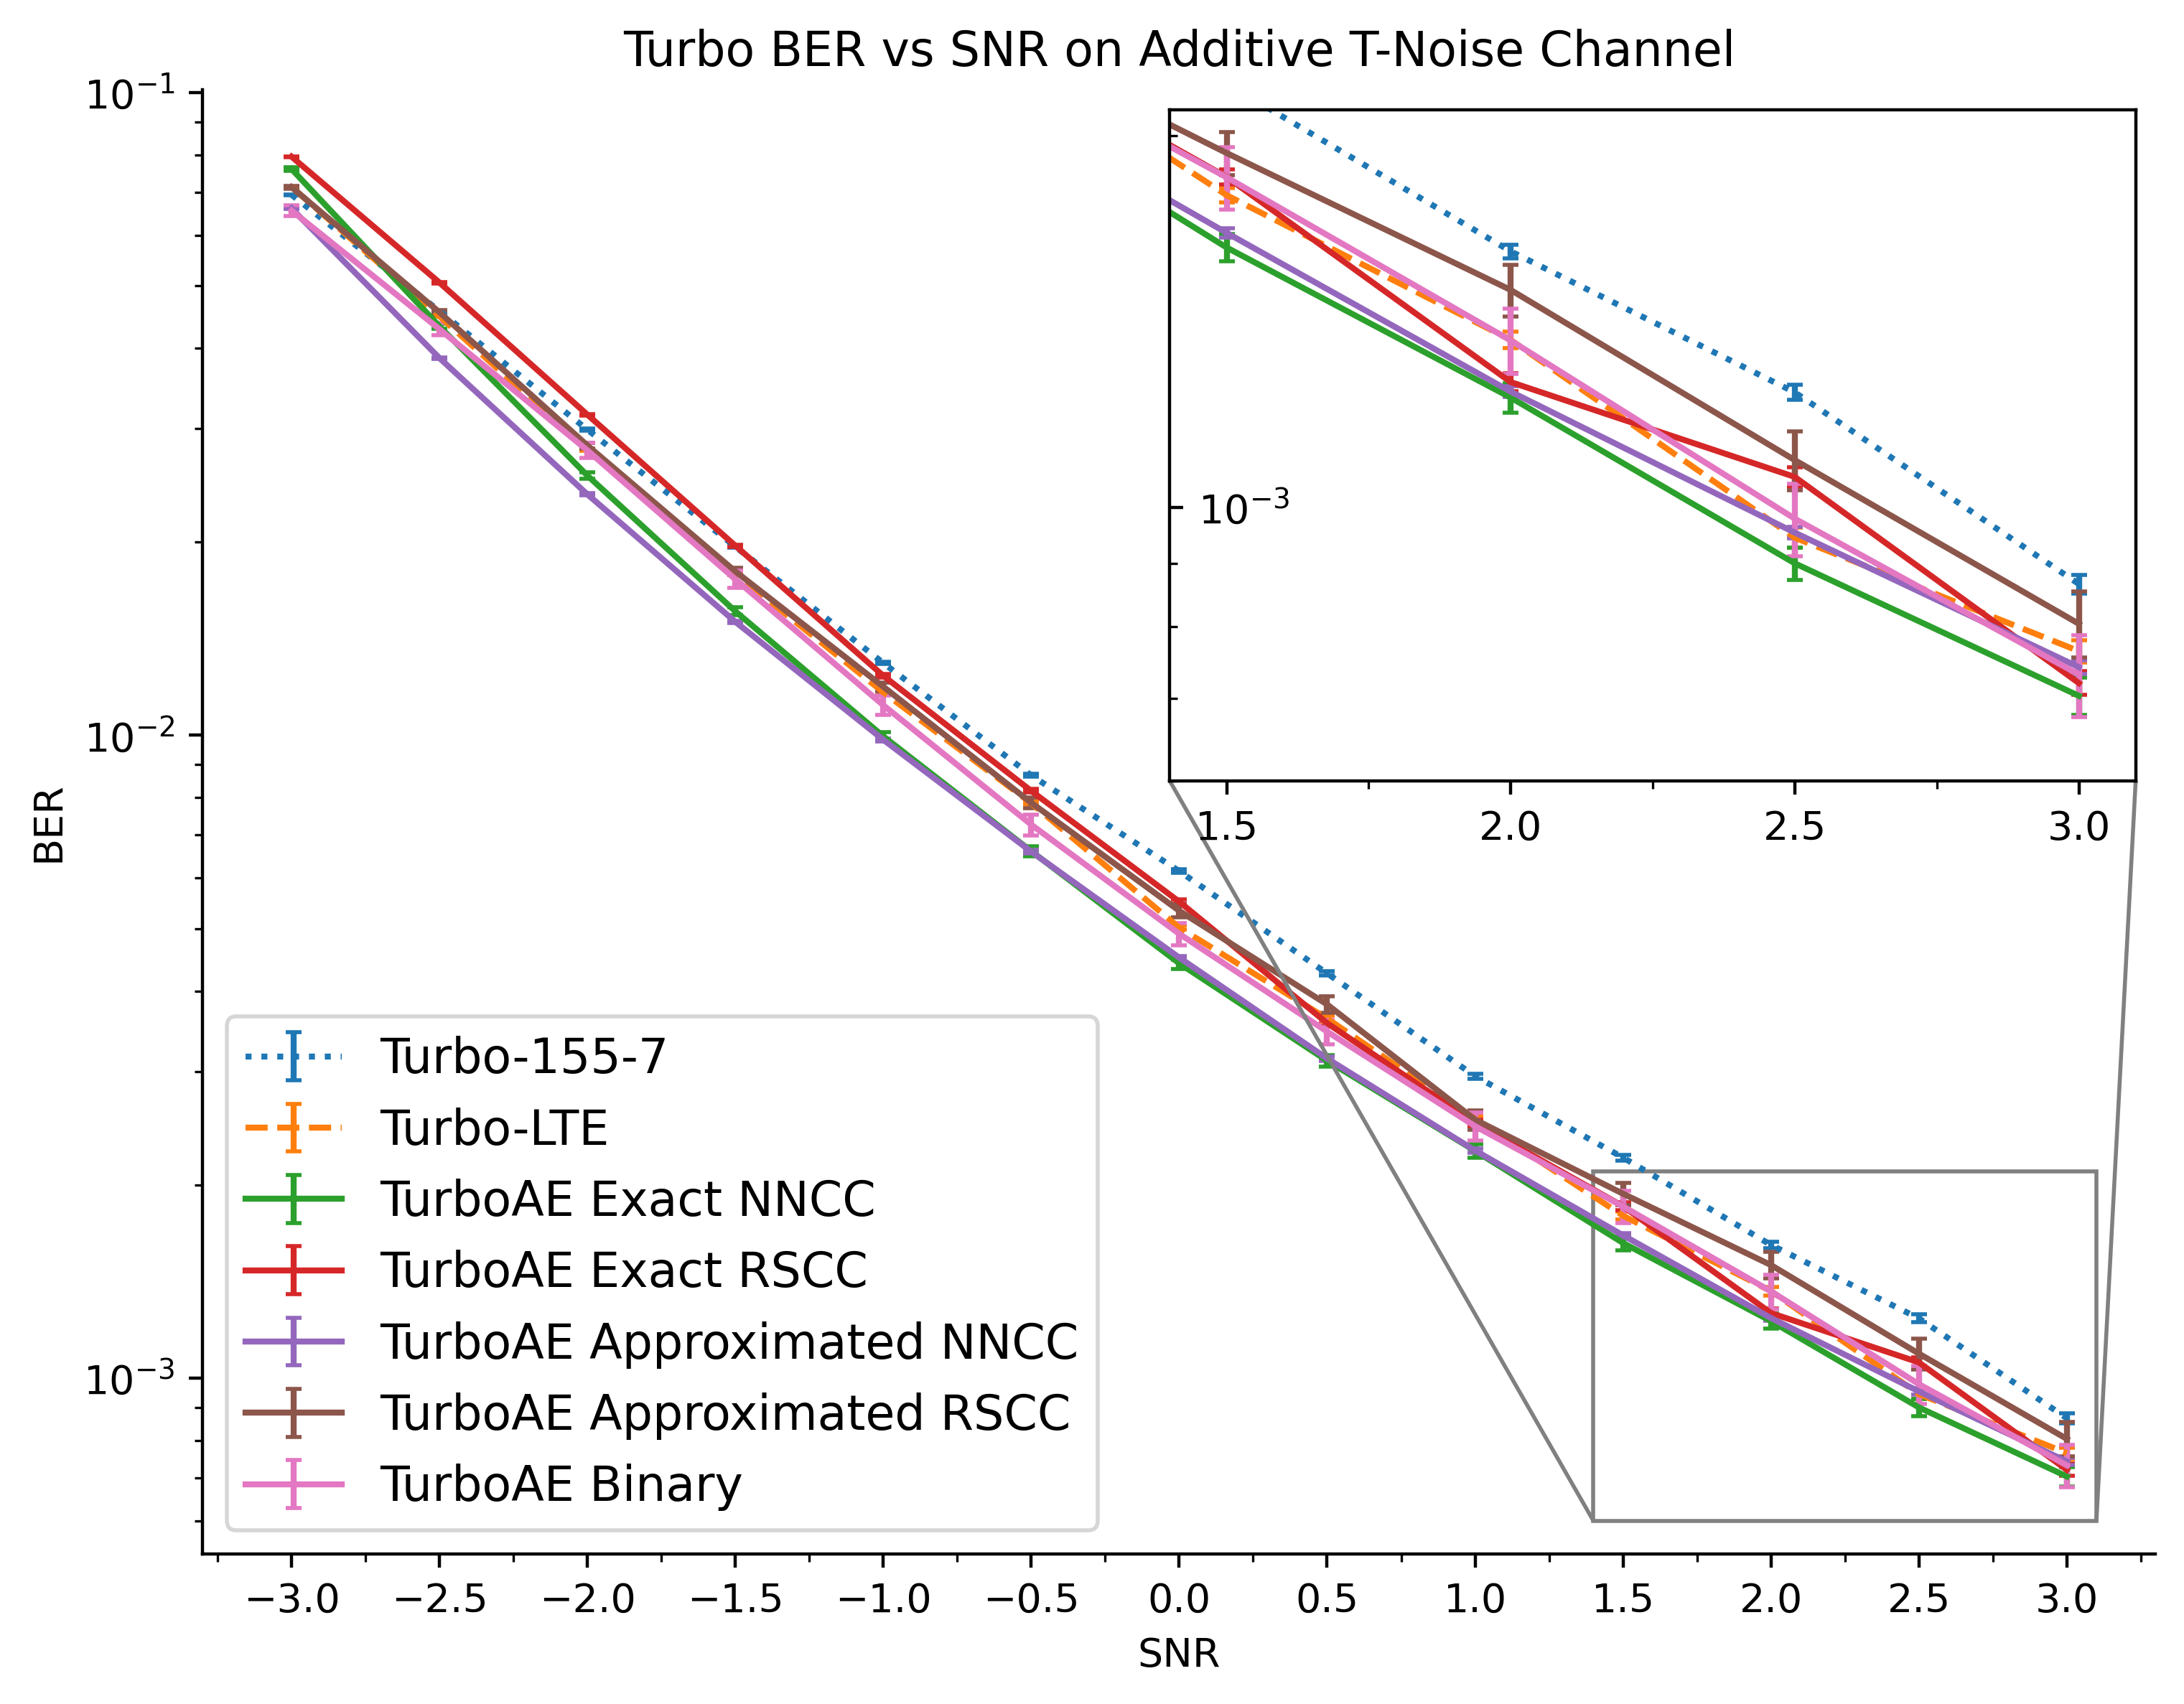

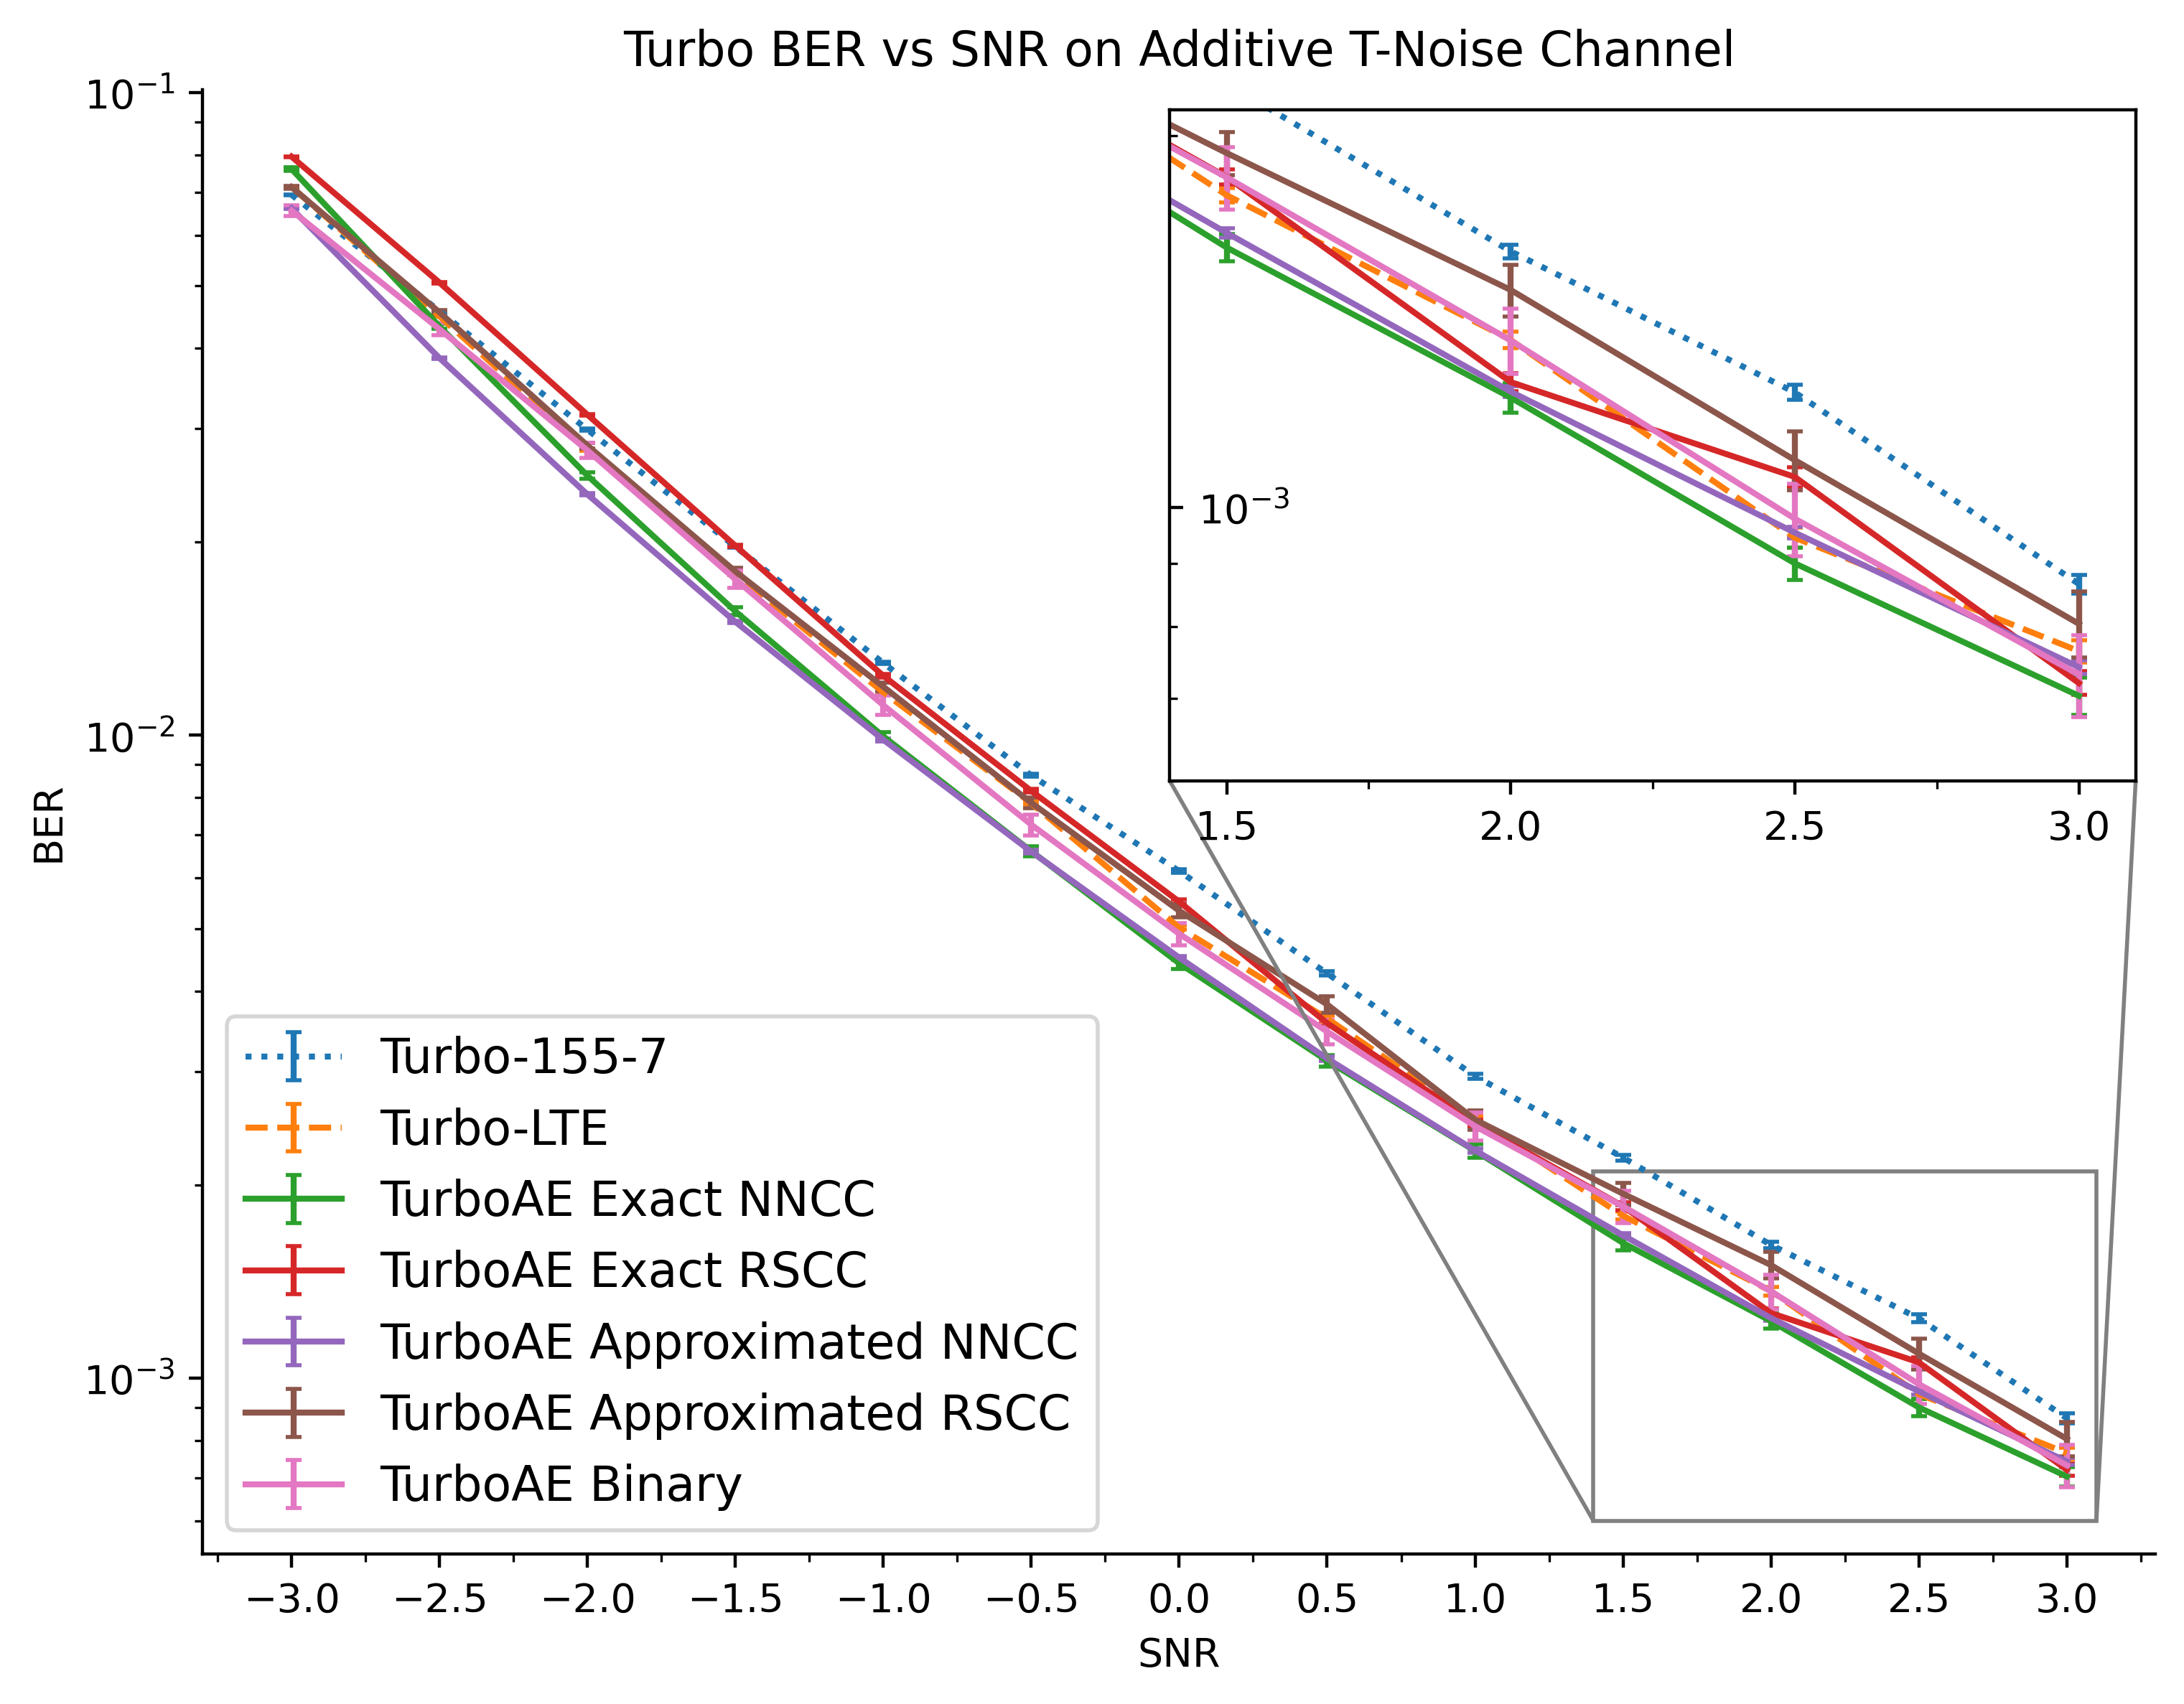

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np

fig = plt.figure(figsize=(8, 6), dpi=400)
ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
capsize = 2

def plot_ber(
    axes, 
    hide_top=True, 
    hide_right=True, 
    axes_titles=True,
    sci_ylabels=False,
    yticks_in=False,
    xticks_in=False
):
    axes.spines['right'].set_visible(not hide_right)
    axes.spines['top'].set_visible(not hide_top)
    axes.set_yscale('log')
    axes.xaxis.set_minor_locator(AutoMinorLocator(2))
    if axes_titles:
        axes.set_xlabel('SNR')
        axes.set_ylabel('BER')
    
    axes.set_xticks(np.arange(-3.0, 3.5, 0.5))
    
    if sci_ylabels:
        # form = axes.yaxis.get_major_formatter()
        # print(form)
        # form.minor_thresholds = (1, 1)
        # form.label_minor(True)
        # print(form.labelOnlyBase)
        logfmt = mpl.ticker.LogFormatterSciNotation(base=10.0, labelOnlyBase=True)
        axes.yaxis.set_major_formatter(logfmt)
        axes.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
        # axes.ticklabel_format(style='sci', axis='y')
        # axes.set_yticklabels([1e-5])
    if yticks_in:
        axes.tick_params(axis="y",direction="in", pad=-30, which='both')
    if xticks_in:
        axes.tick_params(axis="x",direction="in", pad=-13, which='both')
        
    l1 = axes.errorbar(
        loaded_files[T1557]["snrs"], 
        loaded_files[T1557]["ber_mean"], 
        yerr=loaded_files[T1557]["ber_error_bar_width"], 
        linestyle=':',
        capsize=capsize,
        label=T1557
    )
    l2 = axes.errorbar(
        loaded_files[TLTE]["snrs"], 
        loaded_files[TLTE]["ber_mean"], 
        yerr=loaded_files[TLTE]["ber_error_bar_width"], 
        linestyle='--',
        capsize=capsize,
        label=TLTE
    )
    l3 = axes.errorbar(
        loaded_files[TAE_N]["snrs"], 
        loaded_files[TAE_N]["ber_mean"], 
        yerr=loaded_files[TAE_N]["ber_error_bar_width"], 
        linestyle='-',
        capsize=capsize,
        label=TAE_N
    )
    l4 = axes.errorbar(
        loaded_files[TAE_E_RSC]["snrs"], 
        loaded_files[TAE_E_RSC]["ber_mean"], 
        yerr=loaded_files[TAE_E_RSC]["ber_error_bar_width"], 
        linestyle='-',
        capsize=capsize,
        label=TAE_E_RSC
    )
    l5 = axes.errorbar(
        loaded_files[APP_N]["snrs"], 
        loaded_files[APP_N]["ber_mean"], 
        yerr=loaded_files[APP_N]["ber_error_bar_width"], 
        linestyle='-',
        capsize=capsize,
        label=APP_N
    )
    l6 = axes.errorbar(
        loaded_files[APP_RSC]["snrs"], 
        loaded_files[APP_RSC]["ber_mean"], 
        yerr=loaded_files[APP_RSC]["ber_error_bar_width"], 
        linestyle='-',
        capsize=capsize,
        label=APP_RSC
    )
    l7 = axes.errorbar(
        loaded_files[TAE_BIN]["snrs"], 
        loaded_files[TAE_BIN]["ber_mean"], 
        yerr=loaded_files[TAE_BIN]["ber_error_bar_width"], 
        linestyle='-',
        capsize=capsize,
        label=TAE_BIN
    )
    


if channel_type == 'awgn':
    plot_ber(ax)
    ax.set_title('Turbo BER vs SNR on AWGN Channel')
    # Zoom box 1
    axins = zoomed_inset_axes(ax, 3, loc='upper right' )  # zoom = 6
    plot_ber(axins, hide_top=False, hide_right=False, axes_titles=False, sci_ylabels=True)
    x1, x2, y1, y2 = 2.25, 3.1, 2.5e-6, 1.2e-5
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
    # Zoom box 2
    axins2 = zoomed_inset_axes(ax, 2.5, loc='lower left', bbox_to_anchor=(.02,.02,.02,0), bbox_transform=ax.transAxes)  # zoom = 6
    plot_ber(axins2, hide_top=False, hide_right=False, axes_titles=False, sci_ylabels=True, yticks_in=True, xticks_in=True)
    x1, x2, y1, y2 = -0.25, 0.75, 2e-4, 5e-3
    axins2.set_xlim(x1, x2)
    axins2.set_ylim(y1, y2)
    mark_inset(ax, axins2, loc1=2, loc2=4, fc="none", ec="0.5")
elif channel_type == 'atn':
    plot_ber(ax)
    ax.legend(loc='lower left', fontsize='large')
    ax.set_title('Turbo BER vs SNR on Additive T-Noise Channel')
    # Zoom box 1
    axins = zoomed_inset_axes(ax, 1.92, loc='upper right' )  # zoom = 6
    plot_ber(axins, hide_top=False, hide_right=False, axes_titles=False, sci_ylabels=True, yticks_in=True)
    x1, x2, y1, y2 = 1.4, 3.1, 6e-4, 2.1e-3
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
elif channel_type == 'markov':
    ax.set_title('Turbo BER vs SNR on Markovian AWGN Channel')
else:
    raise ValueError()

fig.savefig(f'{channel_type}_ber_results.png')
fig

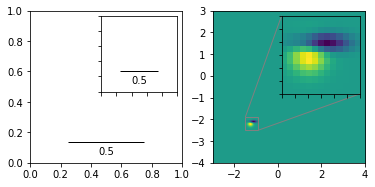

In [75]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import numpy as np


def get_demo_image():
    from matplotlib.cbook import get_sample_data
    import numpy as np
    f = get_sample_data("axes_grid/bivariate_normal.npy", asfileobj=False)
    z = np.load(f)
    # z is a numpy array of 15x15
    return z, (-3, 4, -4, 3)

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=[6, 3])


# First subplot, showing an inset with a size bar.
ax.set_aspect(1)

axins = zoomed_inset_axes(ax, zoom=0.5, loc='upper right')
# fix the number of ticks on the inset axes
axins.yaxis.get_major_locator().set_params(nbins=7)
axins.xaxis.get_major_locator().set_params(nbins=7)

plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)


def add_sizebar(ax, size):
    asb = AnchoredSizeBar(ax.transData,
                          size,
                          str(size),
                          loc=8,
                          pad=0.1, borderpad=0.5, sep=5,
                          frameon=False)
    ax.add_artist(asb)

add_sizebar(ax, 0.5)
add_sizebar(axins, 0.5)


# Second subplot, showing an image with an inset zoom
# and a marked inset
Z, extent = get_demo_image()
Z2 = np.zeros([150, 150], dtype="d")
ny, nx = Z.shape
Z2[30:30 + ny, 30:30 + nx] = Z

# extent = [-3, 4, -4, 3]
ax2.imshow(Z2, extent=extent, interpolation="nearest",
          origin="lower")


axins2 = zoomed_inset_axes(ax2, 6, loc=1)  # zoom = 6
axins2.imshow(Z2, extent=extent, interpolation="nearest",
              origin="lower")

# sub region of the original image
x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)
# fix the number of ticks on the inset axes
axins2.yaxis.get_major_locator().set_params(nbins=7)
axins2.xaxis.get_major_locator().set_params(nbins=7)

plt.setp(axins2.get_xticklabels(), visible=False)
plt.setp(axins2.get_yticklabels(), visible=False)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax2, axins2, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()


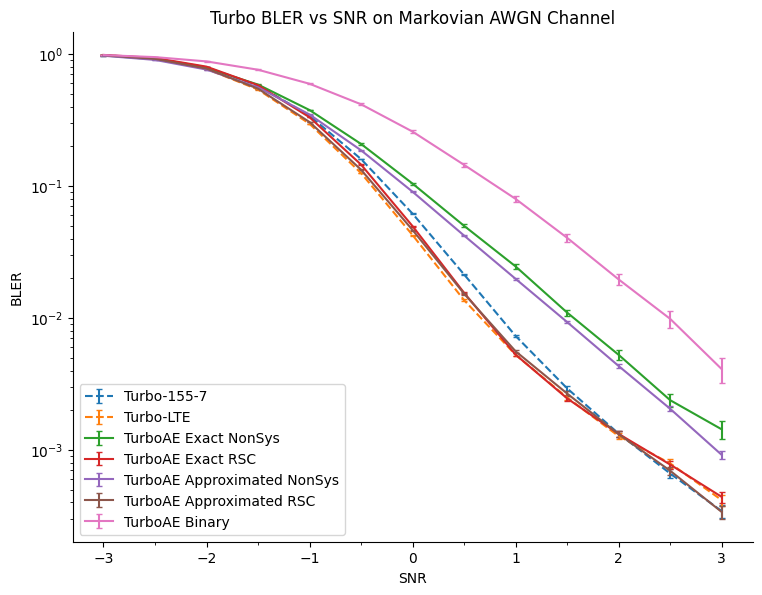

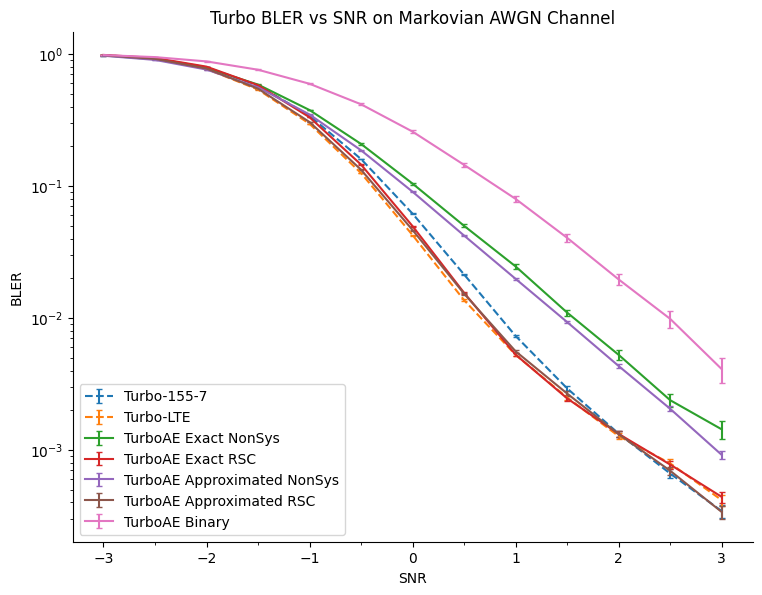

In [71]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
capsize = 2

l1 = ax.errorbar(
    loaded_files[T1557]["snrs"], 
    loaded_files[T1557]["bler_mean"], 
    yerr=loaded_files[T1557]["bler_error_bar_width"], 
    linestyle='--',
    capsize=capsize,
    label=T1557
)
l2 = ax.errorbar(
    loaded_files[TLTE]["snrs"], 
    loaded_files[TLTE]["bler_mean"], 
    yerr=loaded_files[TLTE]["bler_error_bar_width"], 
    linestyle='--',
    capsize=capsize,
    label=TLTE
)
l3 = ax.errorbar(
    loaded_files[TAE_N]["snrs"], 
    loaded_files[TAE_N]["bler_mean"], 
    yerr=loaded_files[TAE_N]["bler_error_bar_width"], 
    linestyle='-',
    capsize=capsize,
    label=TAE_N
)
l4 = ax.errorbar(
    loaded_files[TAE_E_RSC]["snrs"], 
    loaded_files[TAE_E_RSC]["bler_mean"], 
    yerr=loaded_files[TAE_E_RSC]["bler_error_bar_width"], 
    linestyle='-',
    capsize=capsize,
    label=TAE_E_RSC
)
l5 = ax.errorbar(
    loaded_files[APP_N]["snrs"], 
    loaded_files[APP_N]["bler_mean"], 
    yerr=loaded_files[APP_N]["bler_error_bar_width"], 
    linestyle='-',
    capsize=capsize,
    label=APP_N
)
l6 = ax.errorbar(
    loaded_files[APP_RSC]["snrs"], 
    loaded_files[APP_RSC]["bler_mean"], 
    yerr=loaded_files[APP_RSC]["bler_error_bar_width"], 
    linestyle='-',
    capsize=capsize,
    label=APP_RSC
)
l7 = ax.errorbar(
    loaded_files[TAE_BIN]["snrs"], 
    loaded_files[TAE_BIN]["bler_mean"], 
    yerr=loaded_files[TAE_BIN]["bler_error_bar_width"], 
    linestyle='-',
    capsize=capsize,
    label=TAE_BIN
)
ax.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_yscale('log')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('SNR')
ax.set_ylabel('BLER')
if channel_type == 'awgn':
    ax.set_title('Turbo BLER vs SNR on AWGN Channel')
elif channel_type == 'atn':
    ax.set_title('Turbo BLER vs SNR on Markovian Additive T-Noise Channel')
elif channel_type == 'markov':
    ax.set_title('Turbo BLER vs SNR on Markovian AWGN Channel')
else:
    raise ValueError()

fig.savefig(f'{channel_type}_bler_results.png')
fig